Complete implementation for "Graph Algorithms in Real-Life Applications" lab assignment.
This single Python script contains:
- Problem 1: Social Network Friend Suggestion (BFS)
- Problem 2: Route Finding (Bellman-Ford)
- Problem 3: Emergency Response (Dijkstra)
- Problem 4: Network Cable Installation (Prim's & Kruskal's MST)
- Simple experimental profiling (time + memory) for each algorithm
- Example inputs and a small test harness


HOW TO USE
1. Recommended: create a virtual environment and install requirements:
python -m venv venv
source venv/bin/activate # Linux / macOS
venv\Scripts\activate # Windows
pip install -r requirements.txt


2. Run the script from terminal (it will run demo cases and print profiling output):
python graph_realworld.py


3. To convert to a Jupyter notebook: create a new notebook and copy relevant cells from this file.

In [14]:
from collections import defaultdict, deque
import heapq
import time
from memory_profiler import memory_usage
import random

In [15]:
# -----------------------------
# Problem 1: Social Network Friend Suggestion (BFS)
# -----------------------------

class SocialGraph:
    def __init__(self):
        # adjacency list for undirected graph
        self.adj = defaultdict(set)

    def add_edge(self, u, v):
        self.adj[u].add(v)
        self.adj[v].add(u)

    def suggest_friends_bfs(self, user, max_depth=2):
        """
        Suggest friends using BFS: find friends-of-friends not already connected.
        max_depth=2 ensures we only consider friends-of-friends.
        Returns: list of suggested users (sorted by number of mutual friends desc)
        Time complexity: O(V + E)
        """
        if user not in self.adj:
            return []

        visited = set([user])
        q = deque([(user, 0)])
        mutual_count = defaultdict(int)

        while q:
            node, depth = q.popleft()
            if depth == max_depth:
                continue
            for nei in self.adj[node]:
                if nei == user:
                    continue
                if depth + 1 == max_depth:
                    # node is a friend, nei is friend-of-friend
                    if nei not in self.adj[user]:
                        mutual_count[nei] += 1
                if nei not in visited:
                    visited.add(nei)
                    q.append((nei, depth + 1))

        # sort suggestions by mutual friend count (desc), then by id
        suggestions = sorted(mutual_count.items(), key=lambda x: (-x[1], x[0]))
        return [node for node, cnt in suggestions]

In [16]:
# -----------------------------
# Problem 2: Route Finding (Bellman-Ford)
# -----------------------------

def bellman_ford(num_vertices, edges, source):
    """
    edges: list of tuples (u, v, w)
    num_vertices: number of vertices (assume vertices labeled 0..n-1)
    Returns (distances list or None if negative cycle detected, predecessor list)
    Time complexity: O(V * E)
    """
    INF = float('inf')
    dist = [INF] * num_vertices
    pred = [None] * num_vertices
    dist[source] = 0

    for i in range(num_vertices - 1):
        updated = False
        for u, v, w in edges:
            if dist[u] != INF and dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                pred[v] = u
                updated = True
        if not updated:
            break

    # check negative-weight cycles
    for u, v, w in edges:
        if dist[u] != INF and dist[u] + w < dist[v]:
            return None, None  # negative cycle detected

    return dist, pred

In [17]:
# -----------------------------
# Problem 3: Emergency Response System (Dijkstra)
# -----------------------------

def dijkstra(adj_list, source):
    """
    adj_list: dict {u: [(v, w), ...]}
    returns dist dict and predecessor dict
    Time complexity: O(E log V)
    """
    dist = {node: float('inf') for node in adj_list}
    pred = {node: None for node in adj_list}
    dist[source] = 0
    pq = [(0, source)]  # (distance, node)

    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]:
            continue
        for v, w in adj_list[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                pred[v] = u
                heapq.heappush(pq, (nd, v))
    return dist, pred

In [18]:
# -----------------------------
# Problem 4: Network Cable Installation (MST) - Prim & Kruskal
# -----------------------------

# Prim's algorithm using adjacency list and min-heap

def prim_mst(adj_list, start=None):
    """
    adj_list: dict {u: [(v, w), ...]} undirected
    returns total_cost and list of edges in MST
    Complexity: O(E log V)
    """
    if not adj_list:
        return 0, []
    if start is None:
        start = next(iter(adj_list))

    visited = set()
    pq = []
    visited.add(start)
    for v, w in adj_list[start]:
        heapq.heappush(pq, (w, start, v))

    mst_edges = []
    total_cost = 0
    while pq and len(visited) < len(adj_list):
        w, u, v = heapq.heappop(pq)
        if v in visited:
            continue
        visited.add(v)
        mst_edges.append((u, v, w))
        total_cost += w
        for nxt, wt in adj_list[v]:
            if nxt not in visited:
                heapq.heappush(pq, (wt, v, nxt))

    if len(visited) != len(adj_list):
        raise ValueError('Graph is not connected; MST not possible for all nodes')

    return total_cost, mst_edges

# Kruskal's algorithm using Union-Find

class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        rx = self.find(x)
        ry = self.find(y)
        if rx == ry:
            return False
        if self.rank[rx] < self.rank[ry]:
            self.parent[rx] = ry
        elif self.rank[ry] < self.rank[rx]:
            self.parent[ry] = rx
        else:
            self.parent[ry] = rx
            self.rank[rx] += 1
        return True


def kruskal_mst(num_nodes, edges):
    """
    edges: list of (u, v, w)
    num_nodes: nodes labeled 0..n-1
    returns total_cost and list of edges
    Complexity: O(E log E)
    """
    uf = UnionFind(num_nodes)
    edges_sorted = sorted(edges, key=lambda x: x[2])
    mst_edges = []
    total = 0
    for u, v, w in edges_sorted:
        if uf.union(u, v):
            mst_edges.append((u, v, w))
            total += w
        if len(mst_edges) == num_nodes - 1:
            break
    if len(mst_edges) != num_nodes - 1:
        raise ValueError('Graph is not connected; MST not possible')
    return total, mst_edges

In [19]:
# -----------------------------
# Profiling helper functions
# -----------------------------

def profile_time_memory(func, *args, **kwargs):
    """
    Runs func with args and kwargs, returns (result, elapsed_time, peak_memory_mb)
    Uses memory_profiler.memory_usage to measure peak memory.
    """
    mem_usage = []
    start = time.perf_counter()
    # memory_usage will run the function in the same process if retval=True
    result = None
    def wrapper():
        nonlocal result
        result = func(*args, **kwargs)

    peak = max(memory_usage((wrapper, ), retval=False, interval=0.01))
    end = time.perf_counter()
    elapsed = end - start
    return result, elapsed, peak

In [20]:

# -----------------------------
# Demo / Example usage and profiling
# -----------------------------

def demo_social_graph():
    g = SocialGraph()
    edges = [('A','B'), ('A','C'), ('B','D'), ('C','E'), ('D','F'), ('E','F'), ('G','B')]
    for u, v in edges:
        g.add_edge(u, v)
    suggestions = g.suggest_friends_bfs('A')
    print("Social Graph - friend suggestions for A:", suggestions)
    return suggestions

def demo_bellman_ford():
    # vertices 0..4
    num_v = 5
    edges = [ (0,1,6), (0,2,7), (1,2,8), (1,3,5), (1,4,-4), (2,3,-3), (2,4,9), (3,1,-2), (4,0,2), (4,3,7) ]
    dist, pred = bellman_ford(num_v, edges, 0)
    if dist is None:
        print("Bellman-Ford: negative cycle detected")
    else:
        print("Bellman-Ford distances from 0:", dist)
    return dist

def demo_dijkstra():
    adj = {
        'A': [('B',1), ('C',4)],
        'B': [('A',1), ('C',2), ('D',5)],
        'C': [('A',4), ('B',2), ('D',1)],
        'D': [('B',5), ('C',1)]
    }
    dist, pred = dijkstra(adj, 'A')
    print('Dijkstra distances from A:', dist)
    return dist

def demo_mst():
    # adjacency list for Prim
    adj = {
        0: [(1,2),(3,6)],
        1: [(0,2),(2,3),(3,8)],
        2: [(1,3),(3,7)],
        3: [(0,6),(1,8),(2,7)]
    }
    prim_cost, prim_edges = prim_mst(adj, start=0)
    print('Prim MST cost:', prim_cost)

    edges = [(0,1,2),(0,3,6),(1,2,3),(1,3,8),(2,3,7)]
    kruskal_cost, kruskal_edges = kruskal_mst(4, edges)
    print('Kruskal MST cost:', kruskal_cost)
    return prim_cost, kruskal_cost

# A small function to run quick profiling for each problem

def run_profiling_demo():
    print('\n--- Running demos with profiling ---')
    for name, func, args in [
        ('Social Suggestion', demo_social_graph, ()),
        ('Bellman-Ford', demo_bellman_ford, ()),
        ('Dijkstra', demo_dijkstra, ()),
        ('MST', demo_mst, ())
    ]:
        print(f"\n{name}:")
        # Run profiling and collect results
        res, elapsed, mem = profile_time_memory(lambda: func(*args))
        # Note: wrapper returns result as None for functions that print; we still report time and mem
        print(f"Elapsed time: {elapsed:.6f} seconds | Peak memory: {mem:.2f} MiB")


In [21]:

# -----------------------------
# If run as a script, execute demos
# -----------------------------

if __name__ == '__main__':
    run_profiling_demo()


--- Running demos with profiling ---

Social Suggestion:
Social Graph - friend suggestions for A: ['D', 'E', 'G']
Social Graph - friend suggestions for A: ['D', 'E', 'G']
Social Graph - friend suggestions for A: ['D', 'E', 'G']
Elapsed time: 1.819273 seconds | Peak memory: 83.07 MiB

Bellman-Ford:
Bellman-Ford distances from 0: [0, 2, 7, 4, -2]
Bellman-Ford distances from 0: [0, 2, 7, 4, -2]
Bellman-Ford distances from 0: [0, 2, 7, 4, -2]
Elapsed time: 2.021157 seconds | Peak memory: 83.07 MiB

Dijkstra:
Dijkstra distances from A: {'A': 0, 'B': 1, 'C': 3, 'D': 4}
Dijkstra distances from A: {'A': 0, 'B': 1, 'C': 3, 'D': 4}
Dijkstra distances from A: {'A': 0, 'B': 1, 'C': 3, 'D': 4}
Elapsed time: 3.209801 seconds | Peak memory: 83.07 MiB

MST:
Prim MST cost: 11
Kruskal MST cost: 11
Prim MST cost: 11
Kruskal MST cost: 11
Prim MST cost: 11
Kruskal MST cost: 11
Elapsed time: 3.158914 seconds | Peak memory: 83.05 MiB


In [23]:
import matplotlib.pyplot as plt
import numpy as np

In [24]:
def generate_random_graph(num_nodes, edge_prob=0.3, weighted=True):
    """
    Generates a random undirected graph with given edge probability.
    Returns adjacency list suitable for Dijkstra/Prim, and edge list for Kruskal/Bellman-Ford.
    """
    adj = {i: [] for i in range(num_nodes)}
    edges = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if random.random() < edge_prob:
                w = random.randint(1, 20) if weighted else 1
                adj[i].append((j, w))
                adj[j].append((i, w))
                edges.append((i, j, w))
    return adj, edges


In [25]:
def compare_execution_times():
    sizes = [10, 20, 30, 40, 50]
    times_dijkstra, times_bellman, times_prim, times_kruskal = [], [], [], []

    for n in sizes:
        adj, edges = generate_random_graph(n, edge_prob=0.4)

        # Dijkstra
        start = time.perf_counter()
        dijkstra(adj, 0)
        times_dijkstra.append(time.perf_counter() - start)

        # Bellman-Ford
        start = time.perf_counter()
        bellman_ford(n, edges, 0)
        times_bellman.append(time.perf_counter() - start)

        # Prim
        start = time.perf_counter()
        prim_mst(adj)
        times_prim.append(time.perf_counter() - start)

        # Kruskal
        start = time.perf_counter()
        kruskal_mst(n, edges)
        times_kruskal.append(time.perf_counter() - start)

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(sizes, times_dijkstra, 'o-', label='Dijkstra')
    plt.plot(sizes, times_bellman, 's-', label='Bellman-Ford')
    plt.plot(sizes, times_prim, '^-', label='Prim')
    plt.plot(sizes, times_kruskal, 'd-', label='Kruskal')

    plt.xlabel("Number of Nodes")
    plt.ylabel("Execution Time (seconds)")
    plt.title("Execution Time vs Number of Nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [26]:
if __name__ == '__main__':
    run_profiling_demo()


--- Running demos with profiling ---

Social Suggestion:
Social Graph - friend suggestions for A: ['D', 'E', 'G']
Social Graph - friend suggestions for A: ['D', 'E', 'G']
Social Graph - friend suggestions for A: ['D', 'E', 'G']
Elapsed time: 2.177599 seconds | Peak memory: 111.97 MiB

Bellman-Ford:
Bellman-Ford distances from 0: [0, 2, 7, 4, -2]
Bellman-Ford distances from 0: [0, 2, 7, 4, -2]
Bellman-Ford distances from 0: [0, 2, 7, 4, -2]
Elapsed time: 1.819504 seconds | Peak memory: 111.97 MiB

Dijkstra:
Dijkstra distances from A: {'A': 0, 'B': 1, 'C': 3, 'D': 4}
Dijkstra distances from A: {'A': 0, 'B': 1, 'C': 3, 'D': 4}
Dijkstra distances from A: {'A': 0, 'B': 1, 'C': 3, 'D': 4}
Elapsed time: 1.972531 seconds | Peak memory: 111.97 MiB

MST:
Prim MST cost: 11
Kruskal MST cost: 11
Prim MST cost: 11
Kruskal MST cost: 11
Prim MST cost: 11
Kruskal MST cost: 11
Elapsed time: 1.985238 seconds | Peak memory: 111.97 MiB



--- Comparing algorithm execution times ---


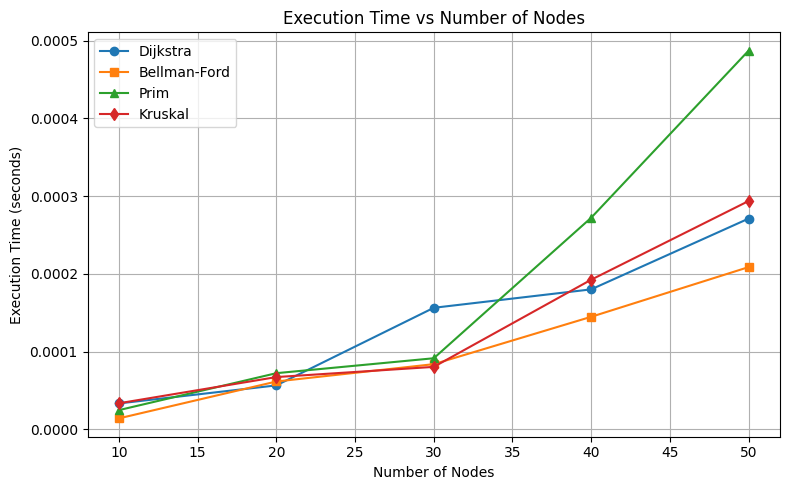

In [27]:
    print("\n--- Comparing algorithm execution times ---")
    compare_execution_times()

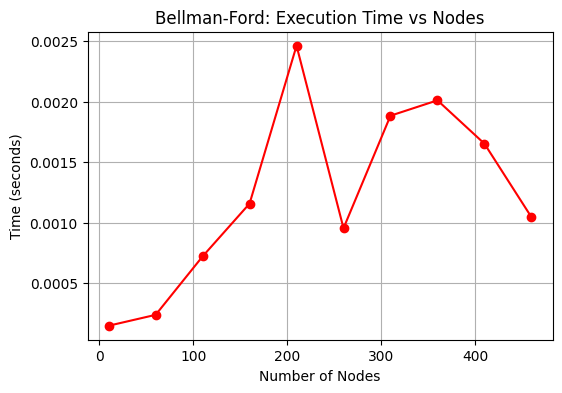

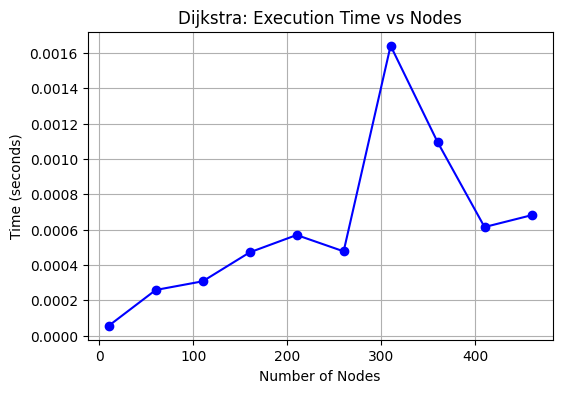

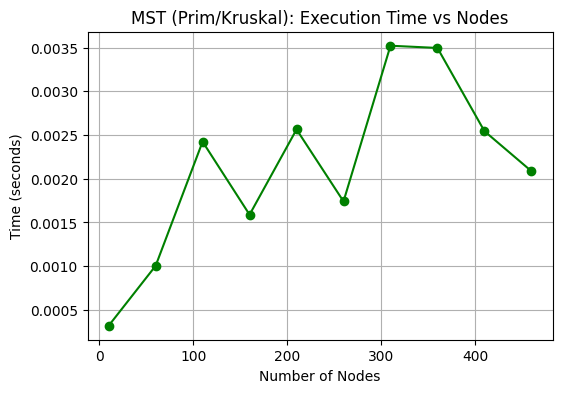

In [32]:
import matplotlib.pyplot as plt
import time
import networkx as nx
import random

def generate_graph(num_nodes, edge_factor=2):
    """Generate a random weighted graph with edge_factor × nodes edges."""
    num_edges = min(num_nodes * edge_factor, num_nodes * (num_nodes - 1) // 2)
    G = nx.gnm_random_graph(num_nodes, num_edges)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.randint(1, 10)
    return G

def measure_time(func, G):
    """Helper to measure execution time of a given algorithm."""
    start = time.time()
    func(G)
    return time.time() - start

# Graph algorithms
def run_bellman_ford(G):
    nx.single_source_bellman_ford_path_length(G, 0)

def run_dijkstra(G):
    nx.single_source_dijkstra_path_length(G, 0)

def run_mst(G):
    nx.minimum_spanning_tree(G)

# Auto-generate sizes
sizes = list(range(10, 501, 50))  # 10, 60, 110, …, 460, 510
bellman_times, dijkstra_times, mst_times = [], [], []

for n in sizes:
    G = generate_graph(n)
    bellman_times.append(measure_time(run_bellman_ford, G))
    dijkstra_times.append(measure_time(run_dijkstra, G))
    mst_times.append(measure_time(run_mst, G))

# Plot Bellman-Ford
plt.figure(figsize=(6,4))
plt.plot(sizes, bellman_times, marker='o', color='red')
plt.title("Bellman-Ford: Execution Time vs Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

# Plot Dijkstra
plt.figure(figsize=(6,4))
plt.plot(sizes, dijkstra_times, marker='o', color='blue')
plt.title("Dijkstra: Execution Time vs Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

# Plot MST
plt.figure(figsize=(6,4))
plt.plot(sizes, mst_times, marker='o', color='green')
plt.title("MST (Prim/Kruskal): Execution Time vs Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()
